In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wave
import os
from scipy.signal import square, ShortTimeFFT, windows, spectrogram
from scipy.signal.windows import gaussian
from scipy.fft import fft, fftshift
from scipy import signal
from scipy.signal.windows import hamming
from scipy.signal import butter, filtfilt

In [14]:
df = pd.read_csv('df_unique_first.csv')

In [15]:
df['FileName'] = df['FileName'].str.split('/').str[-1]
df

FileName  Habitat   Type Season Moment
0   KE-US_20200101_000000_MN_1        1  Close    Wet     MN
1   KE-US_20200101_090000_SR_1        1  Close    Wet     SR
2   KE-US_20200101_120000_MD_1        1  Close    Wet     MD
3   KE-US_20200101_150000_SS_1        1  Close    Wet     SS
4   KE-US_20200601_010000_MN_1        1  Close    Dry     MN
..                         ...      ...    ...    ...    ...
67      WD-AU_20150701_16_SS_1        9  Close    Dry     SS
68      WD-AU_20160101_00_MN_1        9  Close    Wet     MN
69      WD-AU_20160101_04_SR_1        9  Close    Wet     SR
70      WD-AU_20160101_11_MD_1        9  Close    Wet     MD
71      WD-AU_20160101_18_SS_1        9  Close    Wet     SS

[72 rows x 5 columns]

# Add features to df

In [16]:
# Max Amp, Min Amp, Power
def add_features(file_path): 
    try:
        with wave.open(file_path, 'rb') as wav_file:
            frames = wav_file.readframes(wav_file.getnframes())
            num_frames = wav_file.getnframes()
            amplitude_array = np.frombuffer(frames, dtype=np.int16)
            max_amp = np.max(amplitude_array)
            min_amp = np.min(amplitude_array)
            power = np.sqrt(np.sum(amplitude_array.astype(np.float64)**2)/num_frames)
            return max_amp, min_amp, power
        
    except wave.Error as e:
        print(f"Error opening {file_path}: {e}")
        return None, None, None

df['Max Amp'] = None
df['Min Amp'] = None
df['Power'] = None

for idx, row in df.iterrows():
    file_name = row['FileName']
    file_path = os.path.join('Selected_WAV_Files', file_name + '.wav')
    max_amp, min_amp, power = add_features(file_path)
    if max_amp is not None and min_amp is not None:
        df.at[idx, 'Max Amp'] = max_amp
        df.at[idx, 'Min Amp'] = min_amp
        df.at[idx, 'Power'] = power

df

FileName  Habitat   Type Season Moment Max Amp Min Amp  \
0   KE-US_20200101_000000_MN_1        1  Close    Wet     MN    1230   -1261   
1   KE-US_20200101_090000_SR_1        1  Close    Wet     SR    1796   -1493   
2   KE-US_20200101_120000_MD_1        1  Close    Wet     MD    1728   -1626   
3   KE-US_20200101_150000_SS_1        1  Close    Wet     SS    1785   -1594   
4   KE-US_20200601_010000_MN_1        1  Close    Dry     MN    1504   -1491   
..                         ...      ...    ...    ...    ...     ...     ...   
67      WD-AU_20150701_16_SS_1        9  Close    Dry     SS    1218   -1414   
68      WD-AU_20160101_00_MN_1        9  Close    Wet     MN    1726   -1368   
69      WD-AU_20160101_04_SR_1        9  Close    Wet     SR    1310   -1625   
70      WD-AU_20160101_11_MD_1        9  Close    Wet     MD    1463   -1670   
71      WD-AU_20160101_18_SS_1        9  Close    Wet     SS    1620   -1652   

         Power  
0   384.001976  
1   384.028606  
2   384.006116  
3   384.021001  
4   384.011532  
..         ...  
67   384.00682  
68  384.000659  
69  384.012175  
70  384.003758  
71  384.005993  

[72 rows x 8 columns]

In [17]:
print(df['Power'].min())
print(df['Power'].max())

383.97729258966575
384.02860626630275


In [18]:
print(df['Min Amp'].min())
print(df['Max Amp'].max())

-7452
8388


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FileName  72 non-null     object
 1   Habitat   72 non-null     int64 
 2   Type      72 non-null     object
 3   Season    72 non-null     object
 4   Moment    72 non-null     object
 5   Max Amp   72 non-null     object
 6   Min Amp   72 non-null     object
 7   Power     72 non-null     object
dtypes: int64(1), object(7)
memory usage: 4.6+ KB


In [20]:
df['Habitat'] = df['Habitat'].astype(str)
df['Season'] = df['Season'].astype(str)
df['Moment'] = df['Moment'].astype(str)

# find filename from input 

In [21]:
def find_filenames(habitat, season, moment):
    habitat = habitat.strip()
    season = season.strip()
    moment = moment.strip()
    
    df['Habitat'] = df['Habitat'].astype(str).str.lower()
    df['Season'] = df['Season'].astype(str).str.lower()
    df['Moment'] = df['Moment'].astype(str).str.lower()
    
    habitat = habitat.lower()
    season = season.lower()
    moment = moment.lower()

    filtered_df = df[
        ((df['Habitat'] == habitat) | (habitat == '-')) &
        ((df['Season'] == season) | (season == '-')) &
        ((df['Moment'] == moment) | (moment == '-'))
    ]

    print(filtered_df)

    if filtered_df.empty:
        print("No matching records found.")
        return None, None

    file_names = filtered_df['FileName'].tolist()
    habitat_values = filtered_df['Habitat'].tolist()
    season_values = filtered_df['Season'].tolist()
    moment_values = filtered_df['Moment'].tolist()
    return file_names, habitat_values, season_values, moment_values

In [22]:
df

FileName Habitat   Type Season Moment Max Amp Min Amp  \
0   KE-US_20200101_000000_MN_1       1  Close    Wet     MN    1230   -1261   
1   KE-US_20200101_090000_SR_1       1  Close    Wet     SR    1796   -1493   
2   KE-US_20200101_120000_MD_1       1  Close    Wet     MD    1728   -1626   
3   KE-US_20200101_150000_SS_1       1  Close    Wet     SS    1785   -1594   
4   KE-US_20200601_010000_MN_1       1  Close    Dry     MN    1504   -1491   
..                         ...     ...    ...    ...    ...     ...     ...   
67      WD-AU_20150701_16_SS_1       9  Close    Dry     SS    1218   -1414   
68      WD-AU_20160101_00_MN_1       9  Close    Wet     MN    1726   -1368   
69      WD-AU_20160101_04_SR_1       9  Close    Wet     SR    1310   -1625   
70      WD-AU_20160101_11_MD_1       9  Close    Wet     MD    1463   -1670   
71      WD-AU_20160101_18_SS_1       9  Close    Wet     SS    1620   -1652   

         Power  
0   384.001976  
1   384.028606  
2   384.006116  
3   384.021001  
4   384.011532  
..         ...  
67   384.00682  
68  384.000659  
69  384.012175  
70  384.003758  
71  384.005993  

[72 rows x 8 columns]

In [23]:
def plot_sound(file_name, habitat_value, season_value, moment_value):
    file_path = os.path.join('Selected_WAV_Files', file_name + '.wav')

    try:
        with wave.open(file_path, 'rb') as wav_file:
            num_frames = wav_file.getnframes()
            print(f'num_frames: {num_frames}')

            frames = wav_file.readframes(num_frames)
            print(type(frames))

            signal_array = np.frombuffer(frames, dtype=np.int16)

            sample_rate = wav_file.getframerate()
            print(f'sample_rate: {sample_rate}')

            time_axis = np.linspace(0, num_frames / sample_rate, num=num_frames)

            fig, axs = plt.subplots(2, 2, figsize=(15, 12))

            # Plot waveform
            axs[0, 0].plot(time_axis, signal_array)
            axs[0, 0].set_xlabel('Time [s]', fontsize=15)
            axs[0, 0].set_ylabel('Amplitude', fontsize=15)
            axs[0, 0].tick_params(axis='both', labelsize=15)
            axs[0, 0].grid(True)
            axs[0, 0].set_title(f'Waveform of {file_name}\nHabitat: {habitat_value}, Season: {season_value}, Moment: {moment_value}', fontsize=17)

            # Spectrogram parameters
            nperseg = 512
            noverlap = int(0.75 * nperseg)  # 75% overlap

            # Create a Hamming window
            hamming_window = hamming(nperseg)

            # Plot spectrogram
            f, t, Sxx = signal.spectrogram(signal_array, window=hamming_window, fs=sample_rate,
                                           nperseg=nperseg, noverlap=noverlap)

            pcm = axs[0, 1].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='coolwarm')
            axs[0, 1].set_title('Spectrogram', fontsize=17)
            axs[0, 1].set_ylabel('Frequency [Hz]', fontsize=15)
            axs[0, 1].set_xlabel('Time [s]', fontsize=15)
            axs[0, 1].tick_params(axis='both', labelsize=15)
            fig.colorbar(pcm, ax=axs[0, 1], label='Intensity [dB]')

            # Compute power spectrum in dB
            power_spectrum = 10 * np.log10(np.mean(Sxx, axis=1) + 1e-10)
            max_power = np.max(power_spectrum)
            normalized_power_spectrum = power_spectrum - max_power
            axs[1, 0].semilogx(f, normalized_power_spectrum)
            axs[1, 0].set_title('Long-Term Power Spectrum', fontsize=17)
            axs[1, 0].set_xlabel('Frequency [Hz]', fontsize=15)
            axs[1, 0].set_ylabel('Power [dB]', fontsize=15)
            axs[1, 0].tick_params(axis='both', labelsize=15)
            axs[1, 0].grid(True)
            axs[1, 0].set_ylim(bottom=np.min(normalized_power_spectrum), top=0)  # Normalize to make peak at 0
            
            order_lowpass = 1
            fc_lowpass = 150

            rectified_signal = signal_array * (signal_array > 0)

            b, a = butter(order_lowpass, fc_lowpass / (0.5 * sample_rate), btype='low')
            envelope = filtfilt(b, a, rectified_signal)

            nx = len(envelope)
            tf = np.fft.fft(envelope, nx)
            w = (np.arange(nx) / nx) * sample_rate

            mod_spec_sig = np.abs(tf[:nx // 2])

            mod_spec_sig_normalized = mod_spec_sig / np.max(mod_spec_sig + np.finfo(float).eps)  # Avoid division by zero

            mod_spec_db = 20 * np.log10(mod_spec_sig_normalized + np.finfo(float).eps)  # Small value to avoid log(0)
            
            max_mod_spec_db = np.max(mod_spec_db)
            normalized_mod_spec_db = mod_spec_db - max_mod_spec_db

            axs[1, 1].semilogx(w[:nx // 2], normalized_mod_spec_db, 'r:')
            axs[1, 1].set_title('Modulation Spectrum', fontsize=17)
            axs[1, 1].set_xlabel('Frequency [Hz]', fontsize=15)
            axs[1, 1].set_ylabel('Magnitude [dB]', fontsize=15)
            axs[1, 1].tick_params(axis='both', labelsize=15)
            axs[1, 1].grid(True)

            axs[1, 1].set_ylim(bottom=np.min(normalized_mod_spec_db), top=0)
            axs[1, 1].set_xlim([0, 150])
            axs[1, 1].grid(True)

            plt.tight_layout()
            plt.show()

    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return
# Example   
# plot_sound(file_name, '-', '-', '-')


# Get Input

                          FileName Habitat   Type Season Moment Max Amp  \
1       KE-US_20200101_090000_SR_1       1  Close    wet     sr    1796   
13      HJ-FR_20190501_050000_SR_1       2  Close    wet     sr    1483   
21  TL-US_LA0720120601_050000_SR_1       3  Close    wet     sr    1366   
29      IW-US_20210618_040000_SR_1       4   Open    wet     sr    1101   
33      YY-JP_20170401_050000_SR_1       5  Close    wet     sr    2049   
41      NC-GF_20190401_060000_SR_1       6  Close    wet     sr    1891   
53      DJ-CM_20200301_050000_SR_1       7  Close    wet     sr    1642   
57      CS-BR_20170101_060000_SR_1       8   Open    wet     sr    1489   
69          WD-AU_20160101_04_SR_1       9  Close    wet     sr    1310   

   Min Amp       Power  
1    -1493  384.028606  
13   -1490  384.004707  
21   -1397  383.993573  
29   -1167  384.005697  
33   -3777   384.01067  
41   -1836   384.00544  
53   -1551  384.004195  
57   -1586  384.005575  
69   -1625  384.012175  

C:\Users\aslan\AppData\Local\Temp\ipykernel_9384\2703212136.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[1, 1].set_xlim([0, 150])


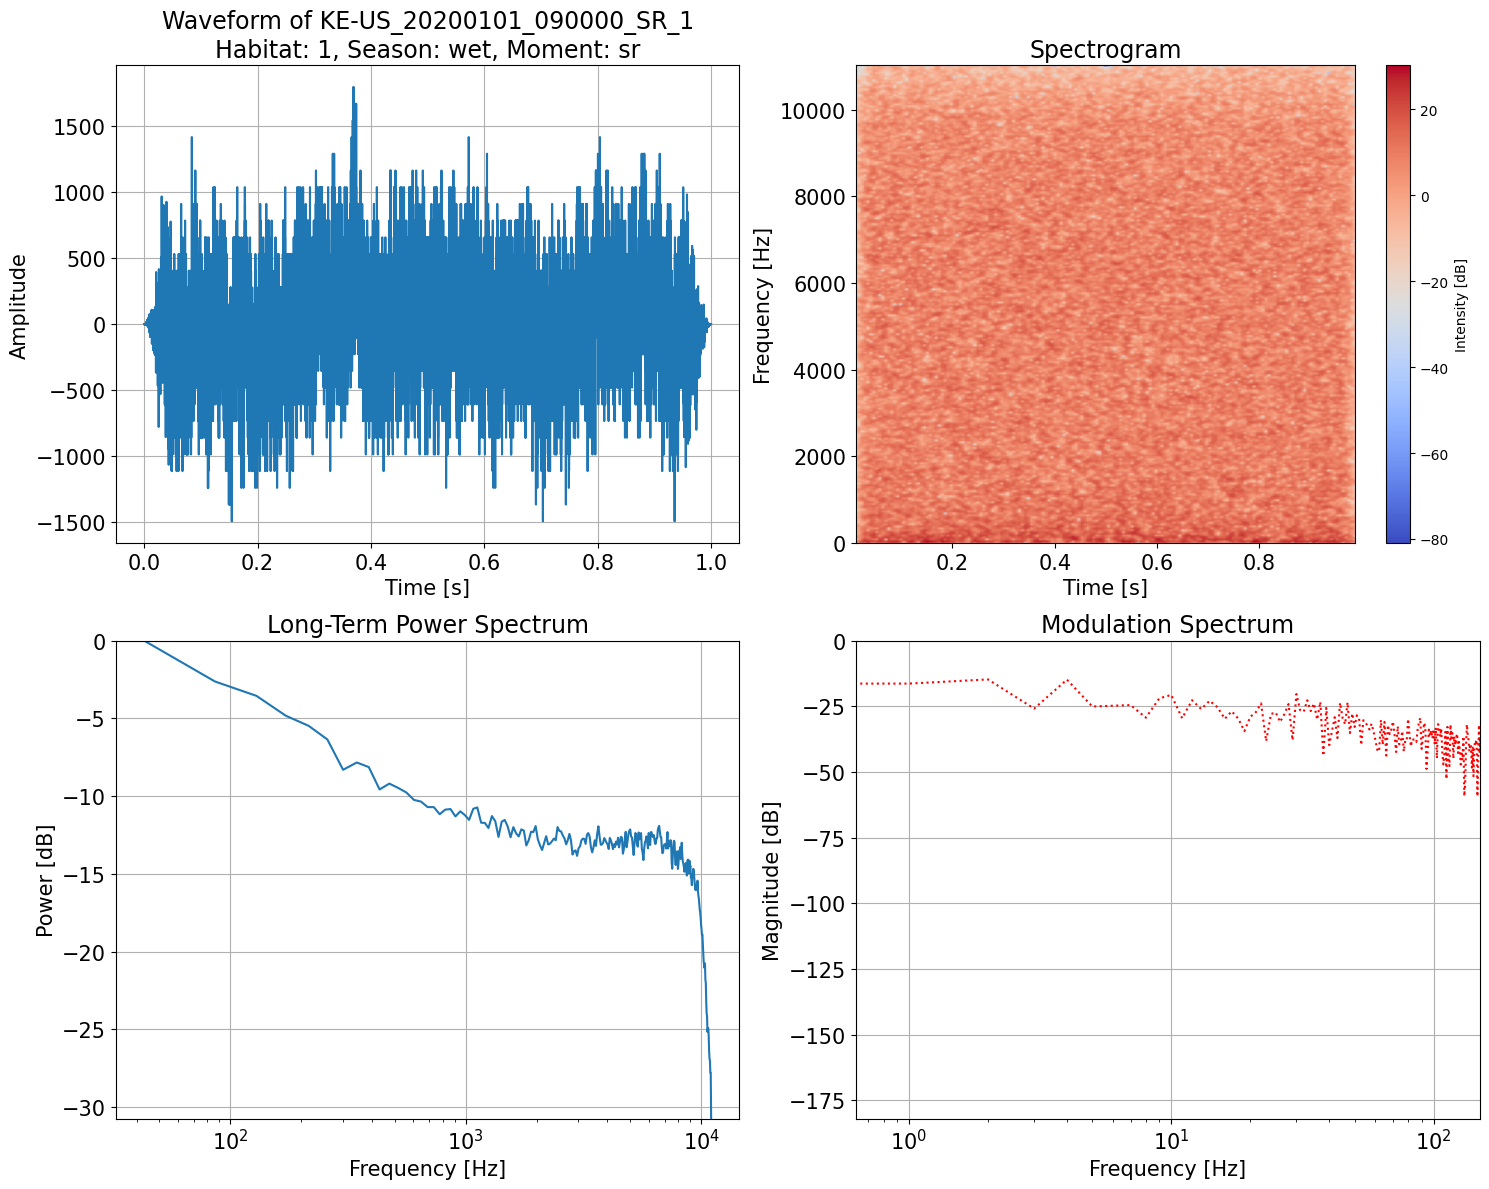

- HJ-FR_20190501_050000_SR_1
num_frames: 22050
<class 'bytes'>
sample_rate: 22050


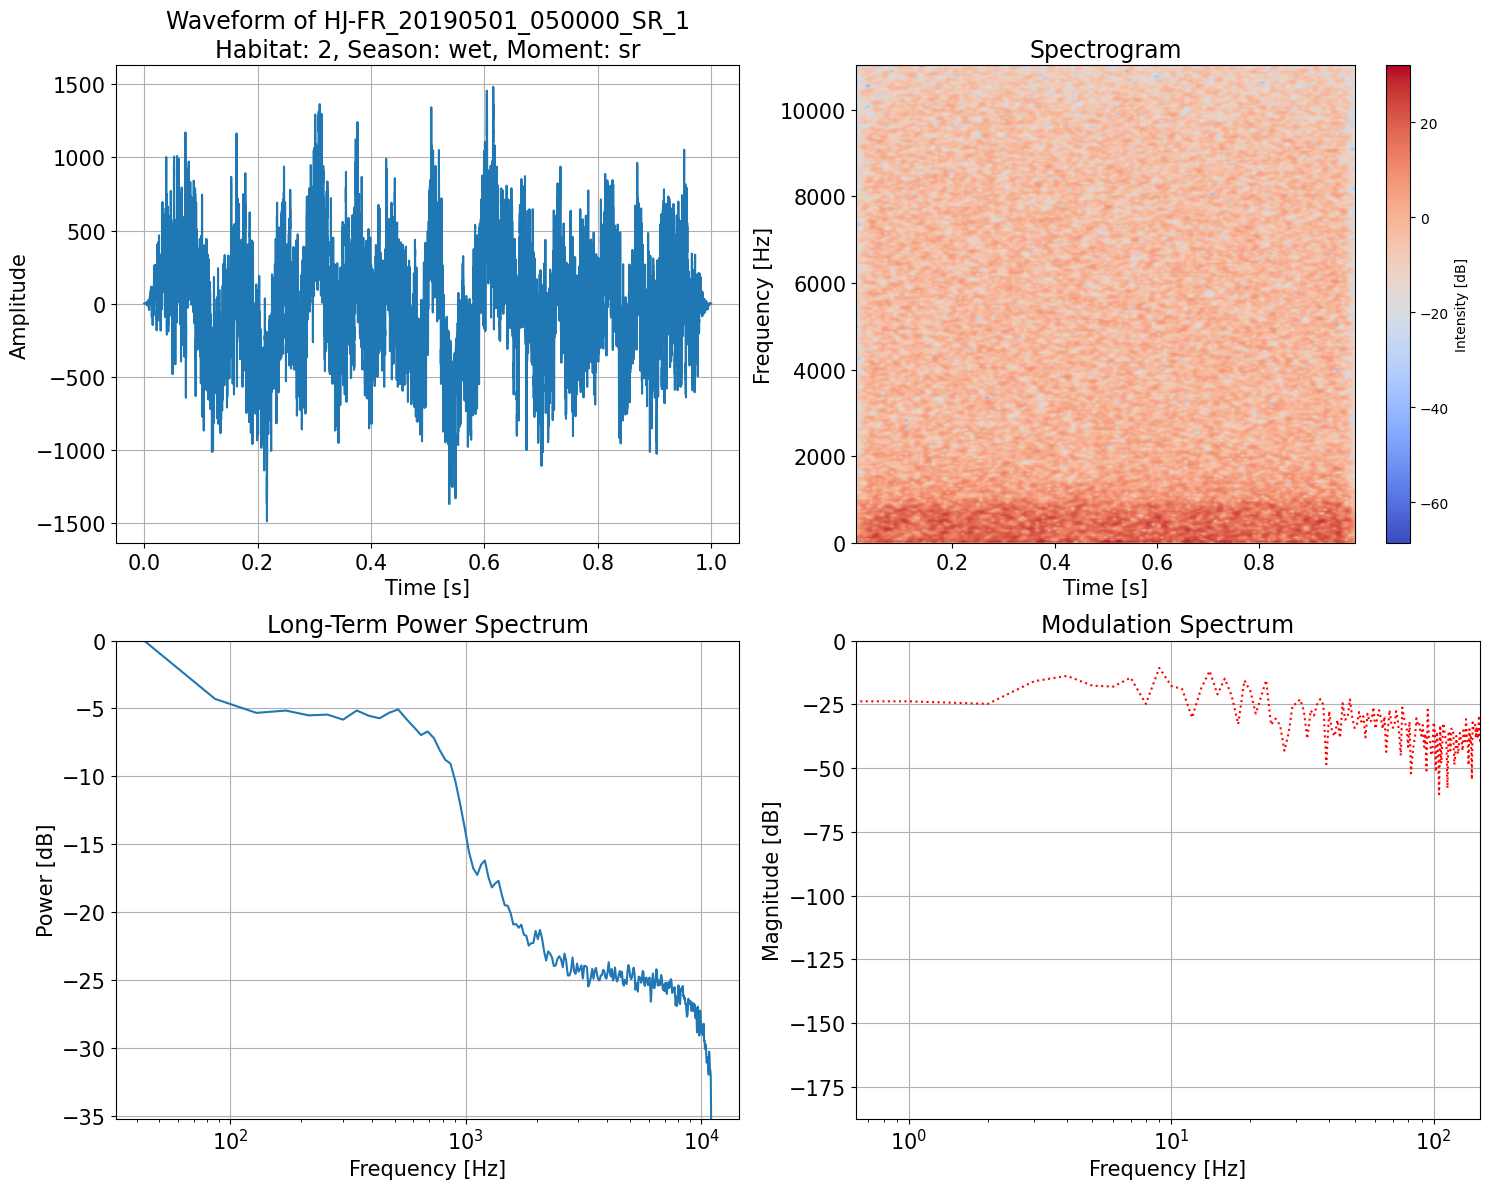

- TL-US_LA0720120601_050000_SR_1
num_frames: 22050
<class 'bytes'>
sample_rate: 22050


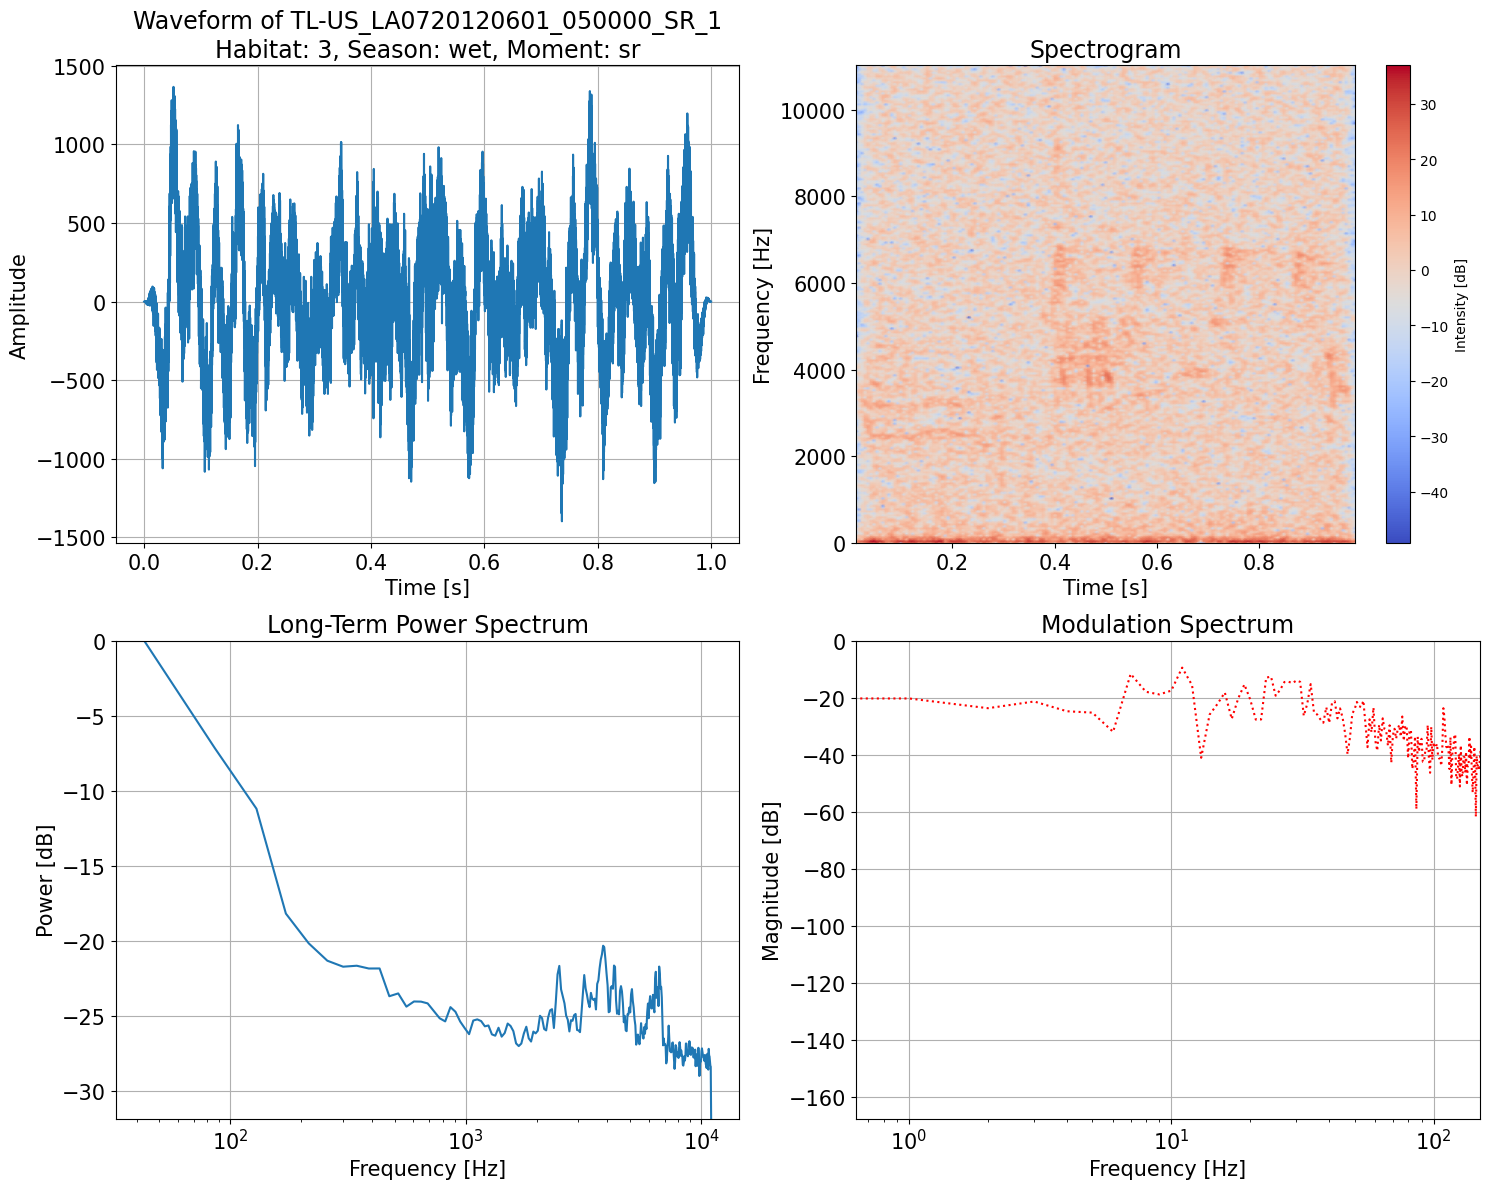

- IW-US_20210618_040000_SR_1
num_frames: 22050
<class 'bytes'>
sample_rate: 22050


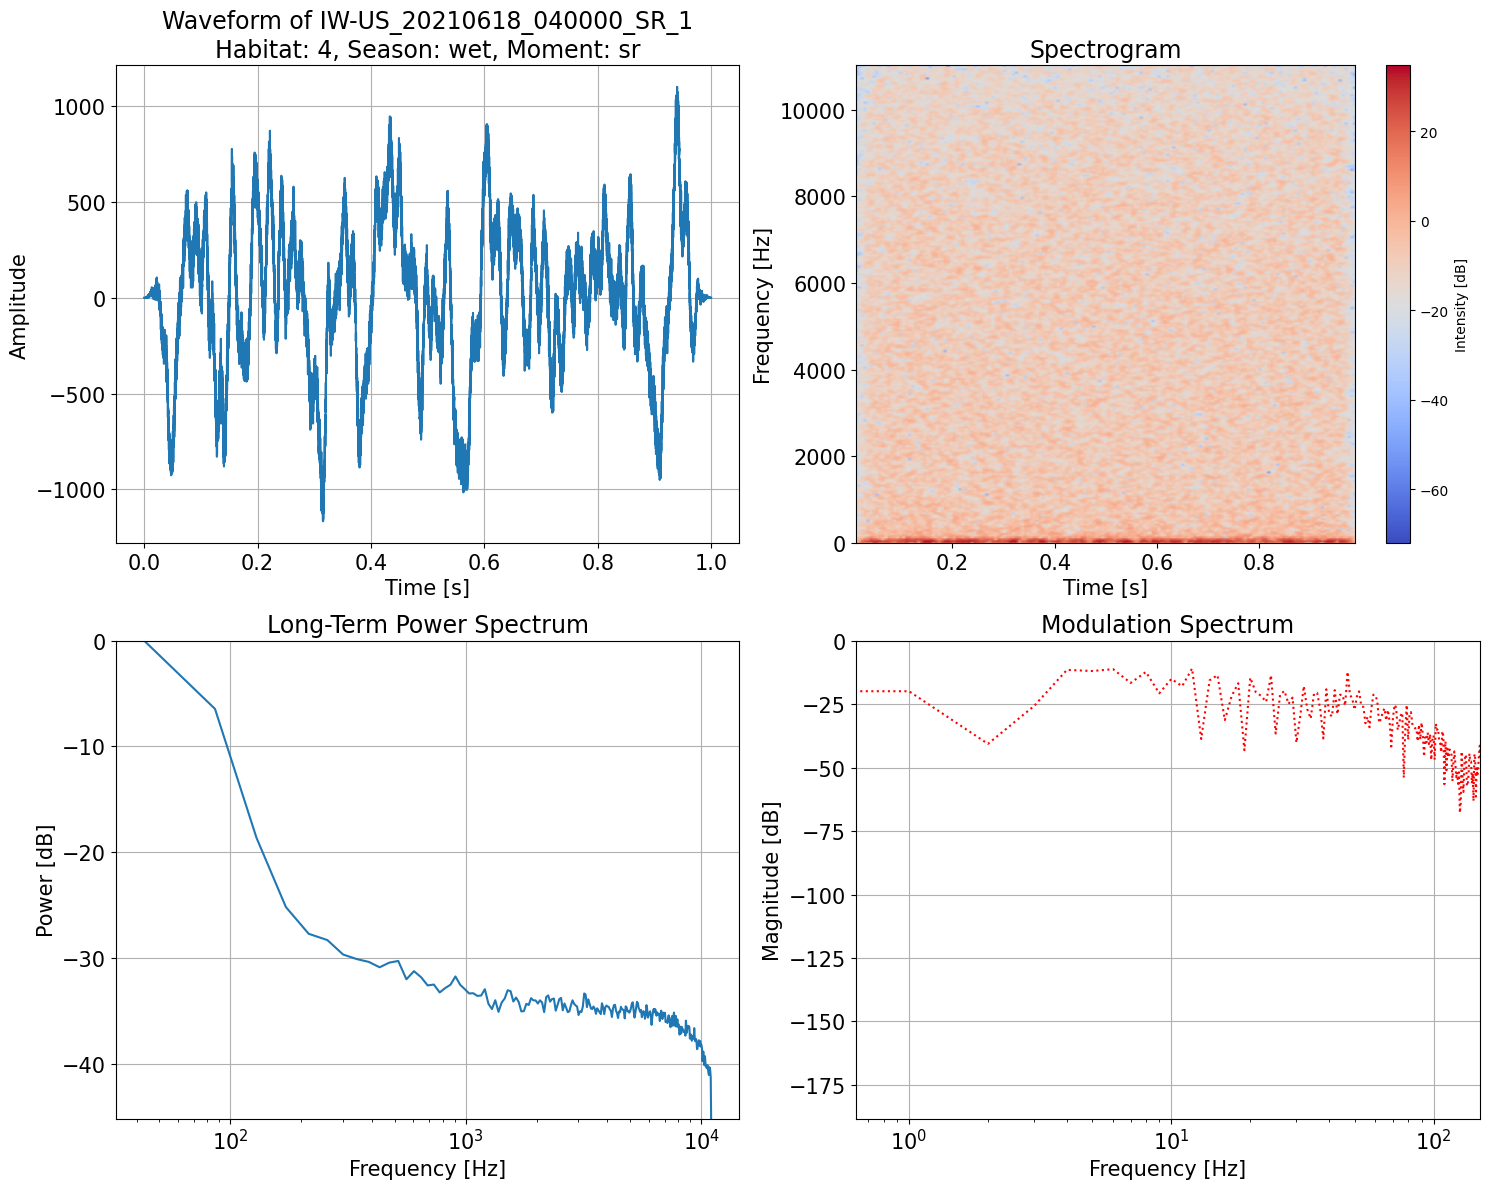

- YY-JP_20170401_050000_SR_1
num_frames: 22050
<class 'bytes'>
sample_rate: 22050


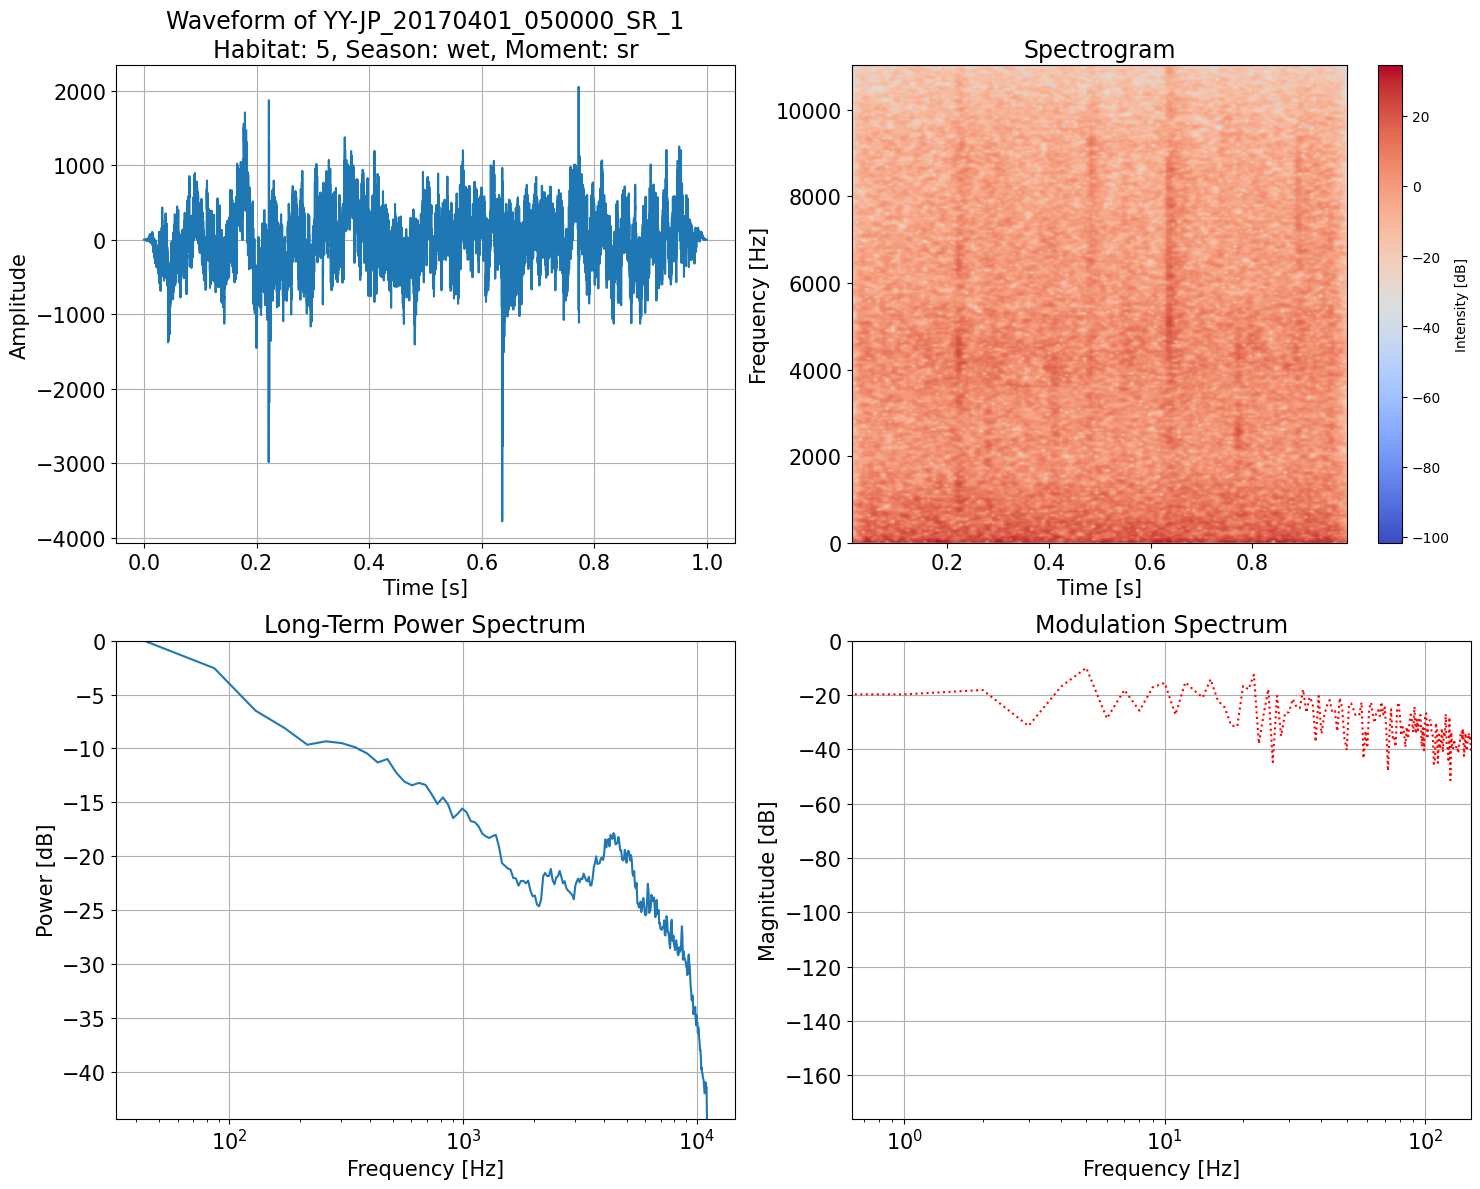

- NC-GF_20190401_060000_SR_1
num_frames: 22050
<class 'bytes'>
sample_rate: 22050


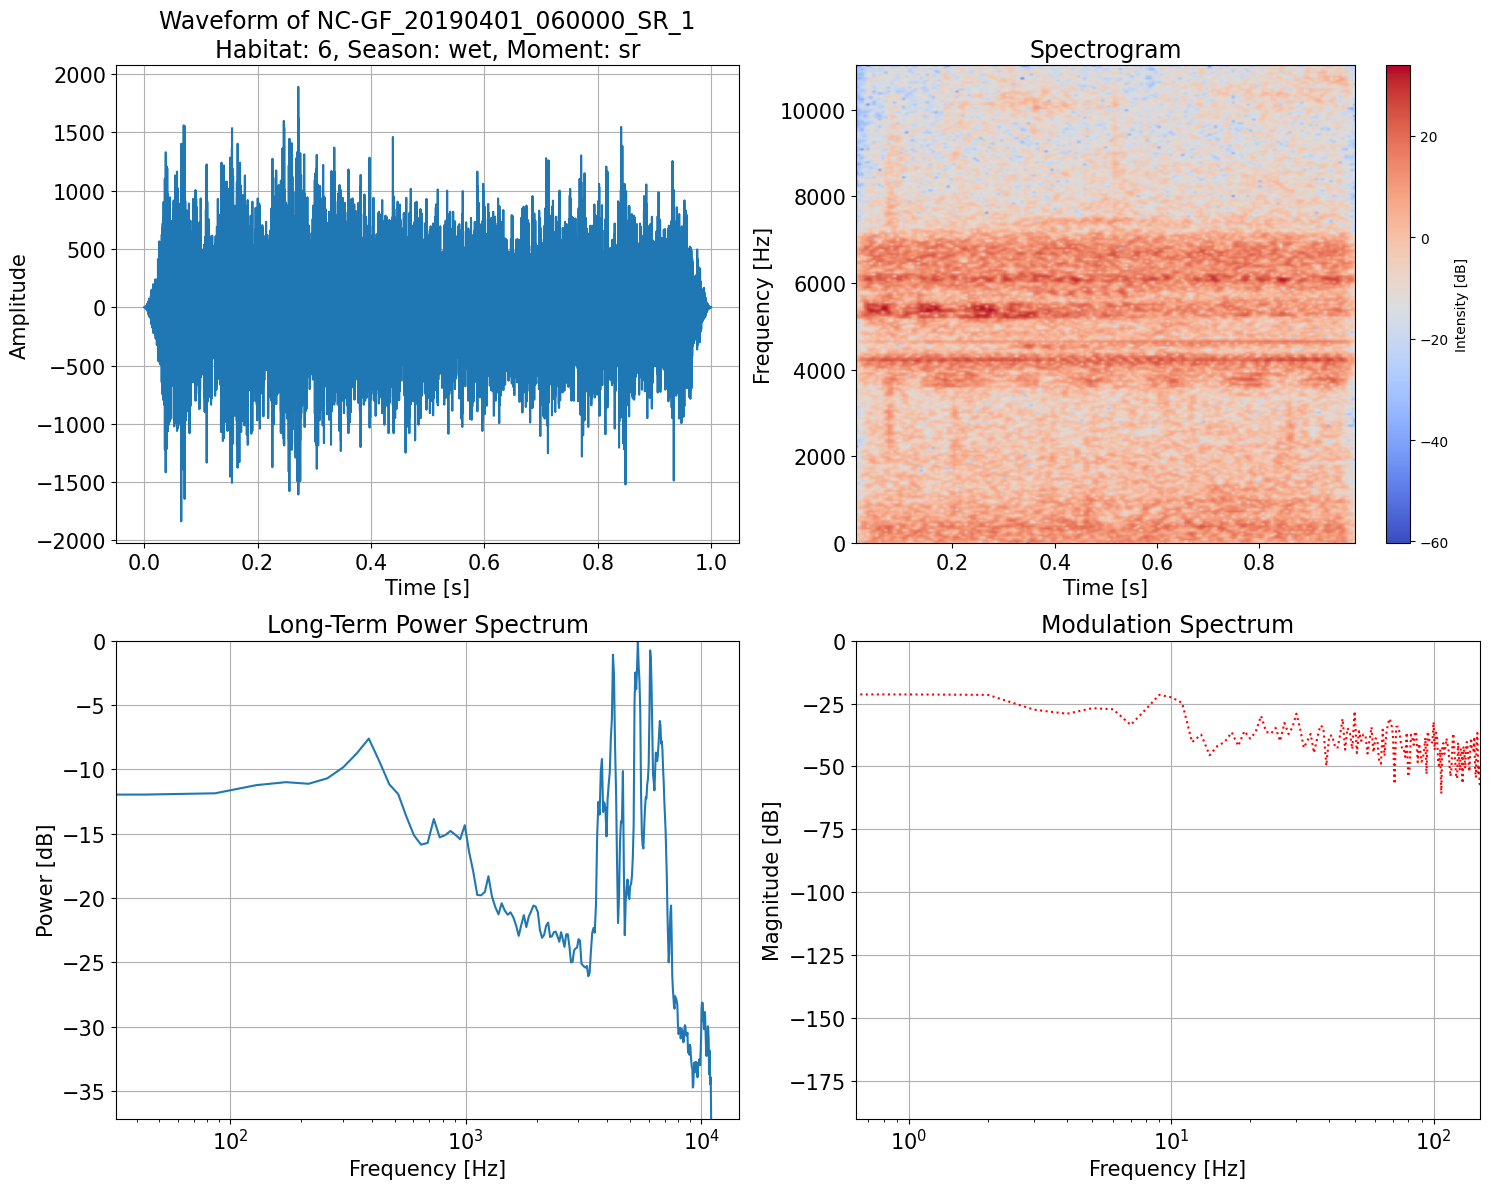

- DJ-CM_20200301_050000_SR_1
num_frames: 22050
<class 'bytes'>
sample_rate: 22050


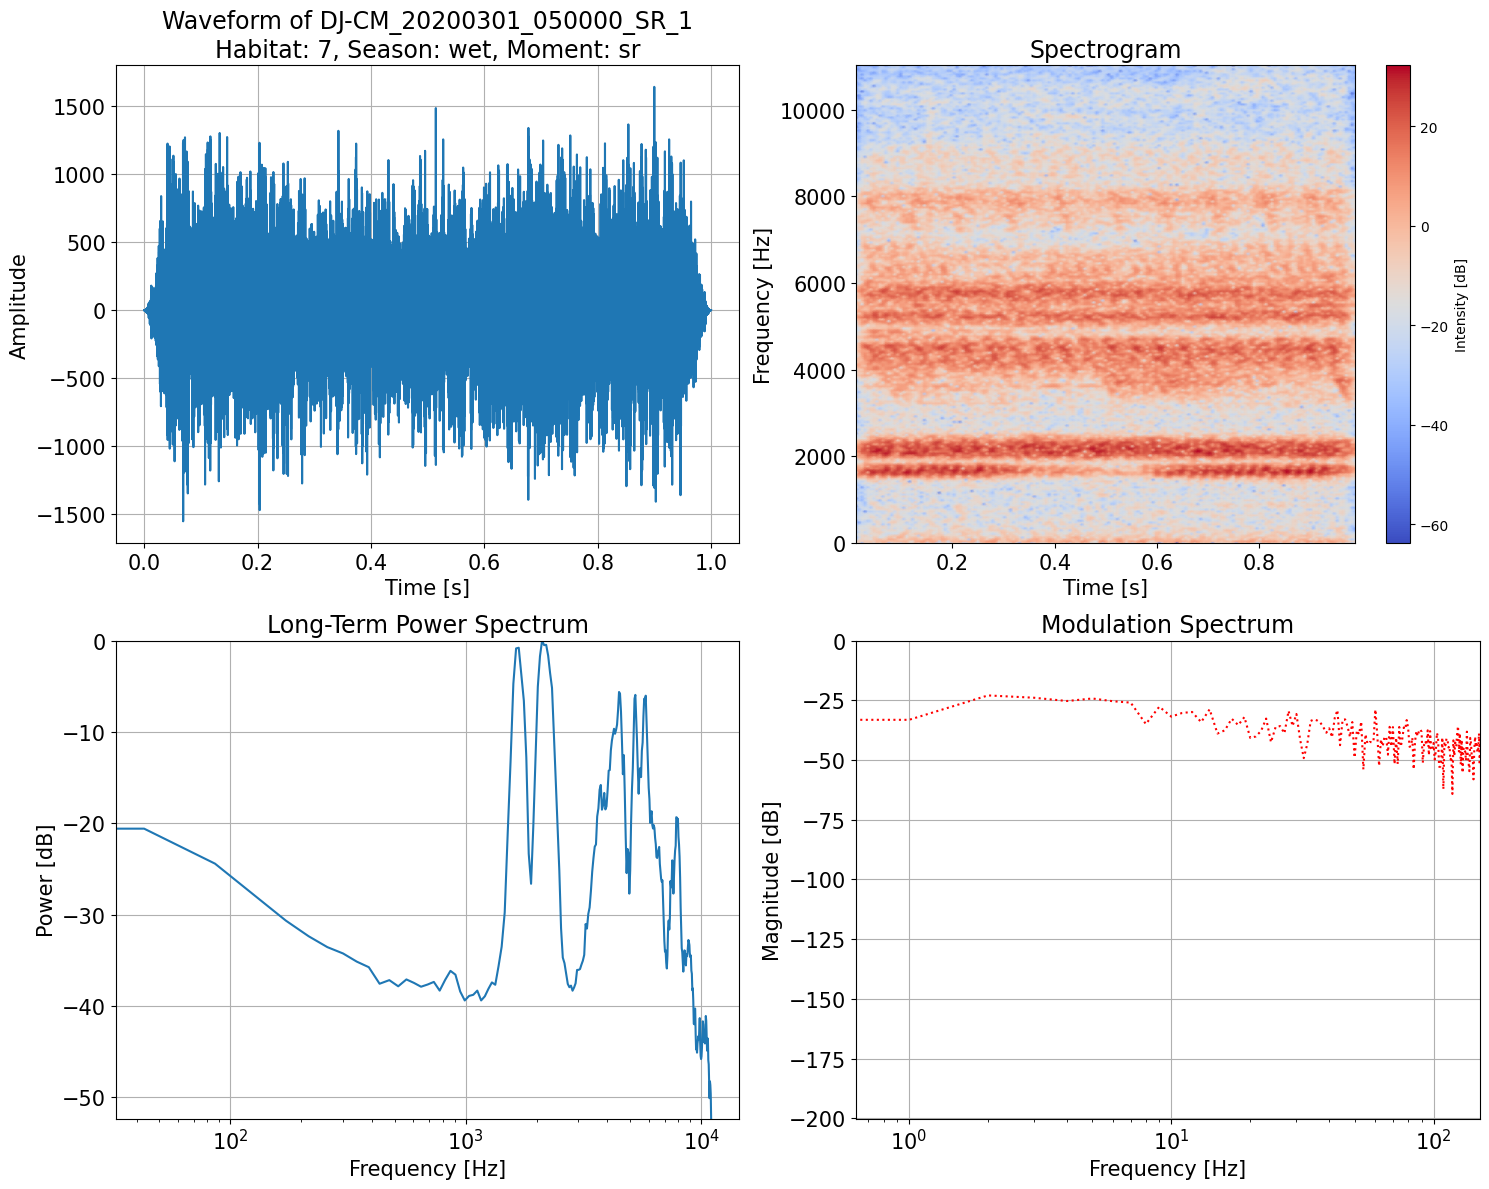

- CS-BR_20170101_060000_SR_1
num_frames: 22050
<class 'bytes'>
sample_rate: 22050


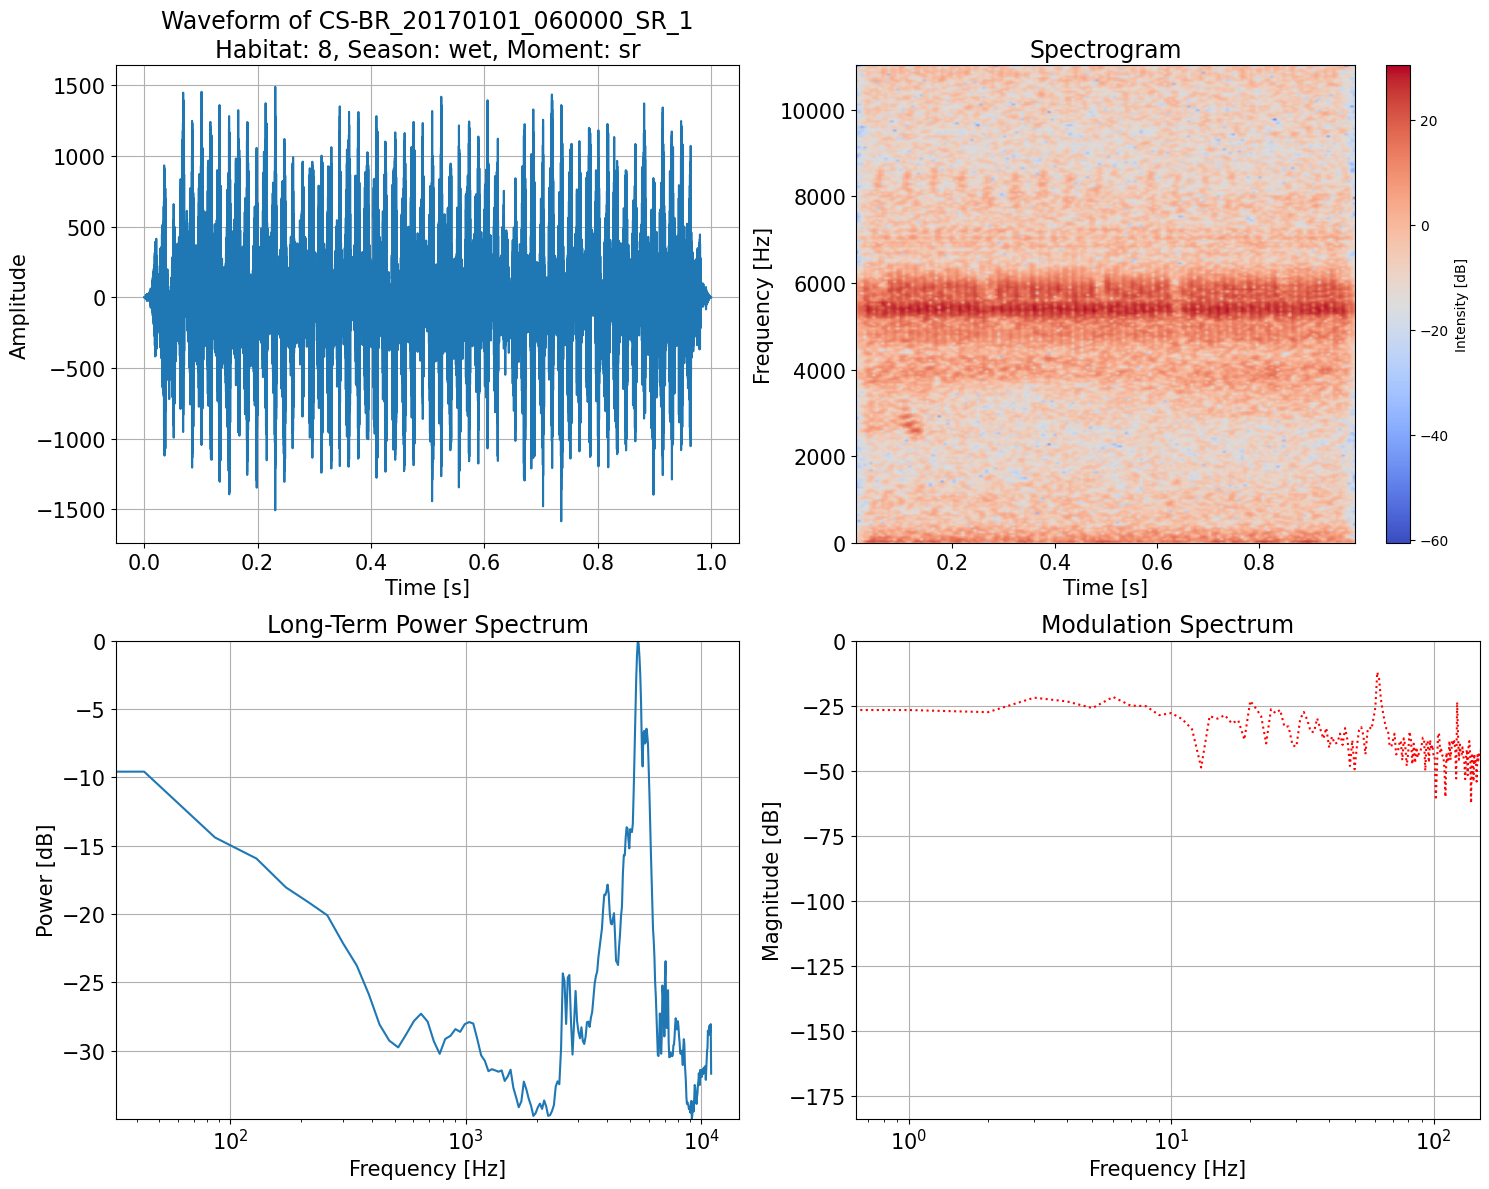

- WD-AU_20160101_04_SR_1
num_frames: 22050
<class 'bytes'>
sample_rate: 22050


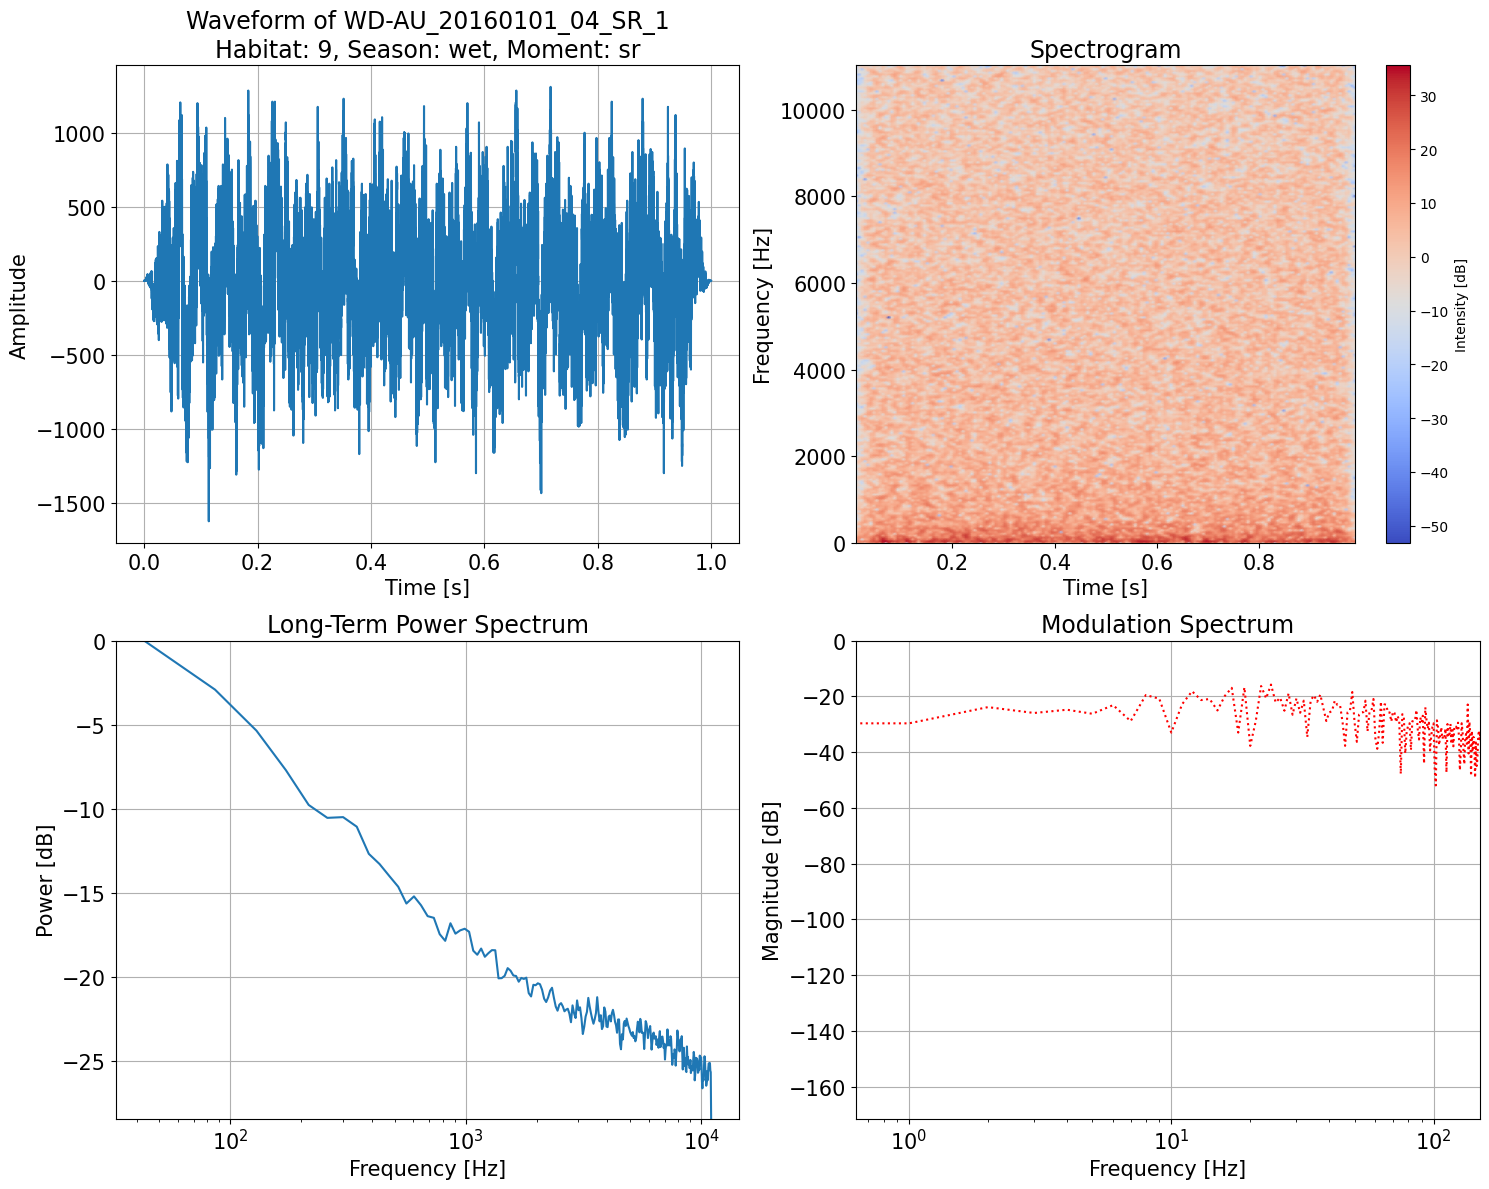

In [24]:
habitat = input("Enter Habitat (or '-' for all): ")
season = input("Enter Season (or '-' for all): ")
moment = input("Enter Moment (or '-' for all): ")

file_names, habitat_values, season_values, moment_values = find_filenames(habitat, season, moment)

if file_names:
    print("Plotting waveforms for the following files:")
    for i, file_name in enumerate(file_names):
        print(f"- {file_name}")                                                                         
        plot_sound(file_name, habitat_values[i], season_values[i], moment_values[i])

# Only plot Spectrogram and save image 

In [25]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import wave
# from scipy.signal import spectrogram

# def plot_sound(file_name, habitat_value, season_value, moment_value):
#     file_path = os.path.join('Selected_WAV_Files', file_name + '.wav')

#     try:
#         with wave.open(file_path, 'rb') as wav_file:
#             num_frames = wav_file.getnframes()
#             frames = wav_file.readframes(num_frames)
#             signal_array = np.frombuffer(frames, dtype=np.int16)
#             sample_rate = wav_file.getframerate()

#             # Compute the spectrogram
#             nperseg = 500
#             noverlap = nperseg // 2
#             f, t, Sxx = spectrogram(signal_array, fs=sample_rate, window=('tukey', 0.5), nperseg=nperseg, noverlap=noverlap)

#             # Plot the spectrogram
#             plt.figure(figsize=(15, 8))
#             pcm = plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='coolwarm')
#             plt.title(f'Waveform of {file_name}\nHabitat: {habitat_value}, Season: {season_value}, Moment: {moment_value}, nperseg: {nperseg}', fontsize=17)
#             plt.ylabel('Frequency [Hz]', fontsize=15)
#             plt.xlabel('Time [s]', fontsize=15)
#             plt.tick_params(axis='both', labelsize=15)
#             plt.colorbar(pcm, label='Intensity [dB]')
            
#             # Save the plot to a file, including the nperseg value in the filename
#             output_filename = f"{file_name}_nperseg{nperseg}.jpg"
#             plt.tight_layout()
#             plt.savefig(output_filename, format='jpg')
#             plt.close()

#     except FileNotFoundError:
#         print(f"File {file_path} not found.")

# habitat = input("Enter Habitat (or '-' for all): ")
# season = input("Enter Season (or '-' for all): ")
# moment = input("Enter Moment (or '-' for all): ")

# file_names, habitat_values, season_values, moment_values = find_filenames(habitat, season, moment)

# if file_names:
#     print("Plotting waveforms for the following files:")
#     for i, file_name in enumerate(file_names):
#         print(f"- {file_name}")                                                                         
#         plot_sound(file_name, habitat_values[i], season_values[i], moment_values[i])


# make a video from all saved images

In [26]:
# import cv2
# import os
# import glob

# image_folder = '.'

# image_files = glob.glob(os.path.join(image_folder, '*.jpg'))

# image_files.sort()

# if not image_files:
#     print("No images found to create a video.")
# else:
#     frame = cv2.imread(image_files[0])
#     height, width, layers = frame.shape

#     video_filename = 'output_video.avi'
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(video_filename, fourcc, 1.0, (width, height))

#     for image_file in image_files:
#         print(f'Adding {image_file} to video')
#         image = cv2.imread(image_file)
#         out.write(image) 

#     out.release()
#     print(f"Video saved as {video_filename}")
